<a href="https://colab.research.google.com/github/vicentcamison/idal_ia3/blob/main/3%20Aprendizaje%20profundo%20(II)/Sesion%202/ConvTranspose2D_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ConvTranspose2D examples

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# Syntax:
# nn.ConvTranspose2d(in_channels: int, out_channels: int, kernel_size: Union[T, Tuple[T, T]], stride: Union[T, Tuple[T, T]] = 1, 
# padding: Union[T, Tuple[T, T]] = 0, output_padding: Union[T, Tuple[T, T]] = 0, ...)

# Inpout: (N,Cin,Hin,Win)
# Output: (N,Cout(N,C, Hout, Wout)

# Convertir de 16 canales a 33 usando un kernel cuadrado 3x3, stride=2 y sin padding
m = nn.ConvTranspose2d(in_channels=16, out_channels=33, kernel_size=(3,3), stride=2, padding=0)
# La misma conversión pero con kernel rectangular: H=3, W=5, stride asimétrico (2 en H y 1 en W) y padding asimétrico (4 en H y 2 en W)
m2 = nn.ConvTranspose2d(in_channels=16, out_channels=33, stride=(2,1), kernel_size=(3,5), padding=(4,2))

In [4]:
# Definir un tensor de entrada random
input = torch.randn(1,16,10,10)
#--JUAN: 1 imágen con 16 canales y tamaño 10x10
# Visualizar con print las dimensiones de salida de ambas convoluciones transpuestas
print(m(input).shape, m2(input).shape)

torch.Size([1, 33, 21, 21]) torch.Size([1, 33, 13, 10])


Vamos a ver el efecto de especificar las dimensiones de salida mediante el parámetro output_size.

In [5]:
# Primero define un tensor random de 16 canales e imágenes de  H=12, W=12
input = torch.randn(1,16,12,12)
# define dos capas Conv2d/ConvTranspose2d que mantengan el nº de canales en 16, kernel 3x3, stride=2 y padding=1
downsample = nn.Conv2d(16, 16, 3, stride=2, padding=1)
upsample = nn.ConvTranspose2d(16, 16, 3, stride=2, padding=1)

In [6]:
# Submuestrea 'input' reduciendo sus dimensiones H y W mediante la capa downsample.
# Observa con print las diemensiones del tensor obtenido. ¿Es el resultado esperado?
print(downsample(input).shape)

#--JUAN: Hemos pasado de un tamaño de 12x12 a 6x6: una cuarta parte del área original

torch.Size([1, 16, 6, 6])


In [7]:
# Podremos ahora aplicar un upsample mediante la capa ConvTranspose2d definida anteriormente.
# Realiza el upsample del tensor anterior submuestreado. ¿Obtenemos las dimensiones originales?
print(upsample(downsample(input)).shape)

#--JUAN: No. Se convierte en una imagen de 11x11 en vez de 12x12

torch.Size([1, 16, 11, 11])


In [8]:
# Podemos ajustar las dimensiones de las features de salida con el parámetro output_size. 
# Haz el upsample de la salida anterior forzando a que tengamos el mismo tamaño de features de salida que de entrada.
# Muestra las dimensiones del tensor obtenido ¿qué diferncia observaas con el caso anterior?
print(upsample(downsample(input), output_size=(1,16,12,12)).shape)

#-- JUAN: Ahora sí que se reconstruye la imagen de 12x12

torch.Size([1, 16, 12, 12])


In [9]:
# Repite el downsample y upsample ahora con un tensor de H=11, W=11. Oserva las dimensiones del tensor tras el upsample,
# sin especificar y especificando el output_size. ¿Qué conclusiones extraes?

input_11 = input = torch.randn(1,16,11,11)
print(upsample(downsample(input_11)).shape, upsample(downsample(input_11), output_size=(1,16,11,11)).shape)

#-- JUAN: Ahora son iguales en ambos casos. 

torch.Size([1, 16, 11, 11]) torch.Size([1, 16, 11, 11])


# Parte 2: Montar un autoencodet para reconstruir las imágenes del dataset CIFAR-10

Gran parte del código está copiado de la metodología desarrollada en el Alien vs Predator

In [10]:
#Normaliamso la imagen
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [11]:
#Descargamos los conjuntos necesarios para train y test
batch_size = 4
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [12]:
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()

    #encoder
    self.enc1 = nn.Conv2d(
        in_channels=3, out_channels=8, kernel_size=3
    )
    self.enc2 = nn.Conv2d(
        in_channels=8, out_channels=4, kernel_size=3
    )

    #decoder
    self.dec1 = nn.ConvTranspose2d(
        in_channels=4, out_channels=8, kernel_size=3
    )
    self.dec2 = nn.ConvTranspose2d(
        in_channels=8, out_channels=3, kernel_size=3
    )

  def forward(self, x):
    x = F.relu(self.enc1(x))
    x = F.relu(self.enc2(x))
    x = F.relu(self.dec1(x))
    x = F.relu(self.dec2(x))
    return x

In [15]:
model = Autoencoder()
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
#BUCLE DE ENTRENAMIENTO

model.train()
train_loss = []
epochs = 10
for epoch in range(epochs):

  running_loss = 0.0
  for data in trainloader:
    #cogemos los inputs como una lista de [inputs, labels]
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    #hacemos 0 los parámetros del gradiente
    optimizer.zero_grad()
    #forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, inputs)
    loss.backward()
    optimizer.step()
    #el loss se devuelve como una media sobre el batch_size: deshacemos la media
    running_loss += loss.item() * inputs.size(0)

  loss = running_loss / len(trainloader)
  train_loss.append(loss)
  print('epoch [%d/%d] loss: %.3f' %
        (epoch + 1, epochs, loss))
  
print('Finished Training')

epoch [1/10] loss: 0.592
epoch [2/10] loss: 0.579
epoch [3/10] loss: 0.577
epoch [4/10] loss: 0.576
epoch [5/10] loss: 0.576
epoch [6/10] loss: 0.576
epoch [7/10] loss: 0.576
epoch [8/10] loss: 0.576
epoch [9/10] loss: 0.576
epoch [10/10] loss: 0.576
Finished Training


In [17]:
model.eval()
with torch.no_grad():
  for data in testloader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)

In [26]:
outputs.to(device)
outputs_np = torch.Tensor.numpy(outputs)
outputs_np.to(device)

TypeError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


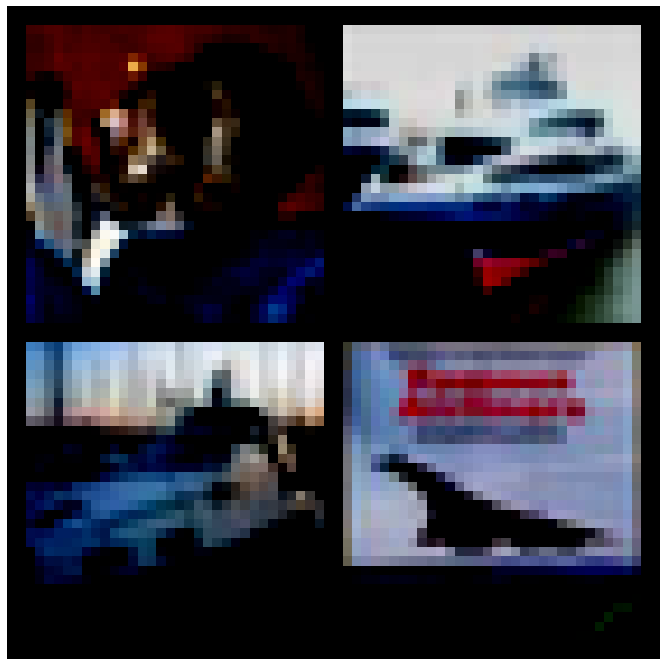

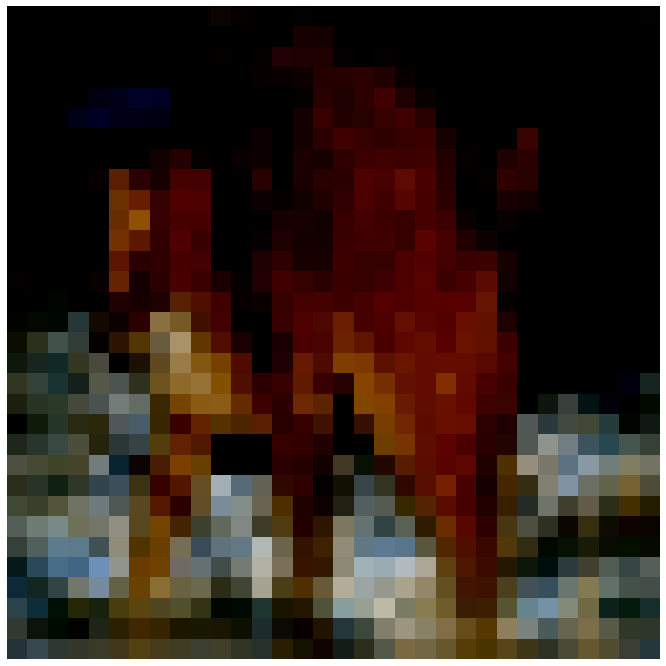

In [28]:
for X, Y in testloader:
  plt.figure(figsize=(12,12))
  grid = torchvision.utils.make_grid(X, nrow=int(np.sqrt(len(X))))
  plt.imshow(grid.permute(1,2,0))
  plt.axis('off')
  plt.show()
  break



for image in outputs.cpu():
  plt.figure(figsize=(12,12))
  grid = torchvision.utils.make_grid(image, nrow=int(np.sqrt(len(X))))
  plt.imshow(grid.permute(1,2,0))
  plt.axis('off')
  plt.show()
  break
  

#MEJORAR ESTE PLOT. QUE SE VEA SIMILAR AL DEL POWERPOINT DEL PROFE

In [24]:
type(outputs)

torch.Tensor

# Eliminación de ruido usando un Autoencoder

In [30]:
#Utilizaremos el Fashion-MNIST

batch_size = 16
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5, inplace=True)])

train_set = torchvision.datasets.FashionMNIST(root = './data/FashionMNIST', train = True, download = True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = torchvision.datasets.FashionMNIST(root = './data/FashionMNIST', train = False, download = True, transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)

In [44]:
class Autoencoder2(nn.Module):
  def __init__(self):
    super(Autoencoder2, self).__init__()

    #encoder
    self.enc1 = nn.Conv2d(
        in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1
    )
    self.enc2 = nn.Conv2d(
        in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1
    )
    self.enc3 = nn.Conv2d(
        in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1
    )
    self.enc4 = nn.Conv2d(
        in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1
    )

    #decoder
    self.dec1 = nn.ConvTranspose2d(
        in_channels=8, out_channels=8, kernel_size=3, padding=0, stride=2
    )
    self.dec2 = nn.ConvTranspose2d(
        in_channels=8, out_channels=16, kernel_size=3, padding=0, stride=2
    )
    self.dec3 = nn.ConvTranspose2d(
        in_channels=16, out_channels=32, kernel_size=2, padding=0, stride=2
    )
    self.dec4 = nn.ConvTranspose2d(
        in_channels=32, out_channels=64, kernel_size=2, padding=0, stride=2
    )
    self.dec5 = nn.ConvTranspose2d(
        in_channels=64, out_channels=1, kernel_size=3, padding=1, stride=1
    )

  def forward(self, x):
    #Relus y max pooling entre cada convolucional en el encoding
    #Relus en el decoder excepto en la última: sigmoide
    x = F.max_pool2d(F.relu(self.enc1(x)), kernel_size=(2,2))
    x = F.max_pool2d(F.relu(self.enc2(x)), kernel_size=(2,2))
    x = F.max_pool2d(F.relu(self.enc3(x)), kernel_size=(2,2))
    x = F.max_pool2d(F.relu(self.enc4(x)), kernel_size=(2,2))
    x = F.relu(self.dec1(x))
    x = F.relu(self.dec2(x))
    x = F.relu(self.dec3(x))
    x = F.relu(self.dec4(x))
    x = F.relu(self.dec5(x))
    return x

In [46]:
model = Autoencoder2()
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [40]:
#Añadimos el ruido a cada imagen
NOISE_FACTOR = 0.5

for X, Y in trainloader:
  X_noisy = X + NOISE_FACTOR * torch.randn(X.shape)
  #forzamos que los valores de la imagen estén entre 0 y 1
  X_noisy = np.clip(X_noisy, 0., 1.)
  X_noisy = X_noisy.to(device)

for X, Y in testloader:
  X_test_noisy = X + NOISE_FACTOR * torch.randn(X.shape)
  #forzamos que los valores de la imagen estén entre 0 y 1
  X_test_noisy = np.clip(X_test_noisy, 0., 1.)
  X_test_noisy = X_test_noisy.to(device)

In [47]:
#BUCLE DE ENTRENAMIENTO

model.train()
train_loss = []
epochs = 10
for epoch in range(epochs):

  running_loss = 0.0
  for data in trainloader:
    #cogemos los inputs como una lista de [inputs, labels]
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    #hacemos 0 los parámetros del gradiente
    optimizer.zero_grad()
    #forward + backward + optimize
    outputs = model(X_noisy)
    loss = criterion(outputs, X_noisy)
    loss.backward()
    optimizer.step()
    #el loss se devuelve como una media sobre el batch_size: deshacemos la media
    running_loss += loss.item() * inputs.size(0)

  loss = running_loss / len(trainloader)
  train_loss.append(loss)
  print('epoch [%d/%d] loss: %.3f' %
        (epoch + 1, epochs, loss))
  
print('Finished Training')

epoch [1/10] loss: 0.599
epoch [2/10] loss: 0.321
epoch [3/10] loss: 0.261
epoch [4/10] loss: 0.229
epoch [5/10] loss: 0.208
epoch [6/10] loss: 0.192
epoch [7/10] loss: 0.179
epoch [8/10] loss: 0.168
epoch [9/10] loss: 0.159
epoch [10/10] loss: 0.151
Finished Training


In [ ]:
model.eval()
with torch.no_grad():
  for data in X_test_noise:
    #images, labels = data
    #images, labels = images.to(device), labels.to(device)
    outputs = model(X_test_)